In [108]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [109]:
#path = 'Data/SIR_Origin/*.csv'
#dic_files = Load_files.load_files(path, -17, -15)
#path = 'Data/Cleaned_deathCnt/*.csv'
#dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [110]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 100
hidden_size = 32
num_layers = 2
batch_size = 64
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

#df = Prepare_df.processing(data, 'Date', 'alpha')
df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')

model_BiLSTM = BiLSTM(input_size = input_size,
                      hidden_size = hidden_size,
                      sequence_length = sequence_length,
                      num_layers = num_layers, 
                      dropout = dropout, 
                      device = device).to(device)

model = model_BiLSTM

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([57, 60, 3])
torch.Size([57, 1])
torch.Size([7, 60, 3])
torch.Size([7, 1])


In [111]:
loss_list, model,= Trainer.Many_to_One(train_loader, 
                                       test_loader, 
                                       model, 
                                       criterion, 
                                       optimizer, 
                                       num_epochs, 
                                       patience,
                                       device)

epoch: 100 loss: 0.0013
epoch: 200 loss: 0.0003
epoch: 300 loss: 0.0002
epoch: 400 loss: 0.0001
epoch: 500 loss: 0.0001
epoch: 600 loss: 0.0001
epoch: 700 loss: 0.0000
epoch: 800 loss: 0.0000
epoch: 900 loss: 0.0000
epoch: 1000 loss: 0.0000

 Early Stopping / epoch: 1001 loss: 0.0000


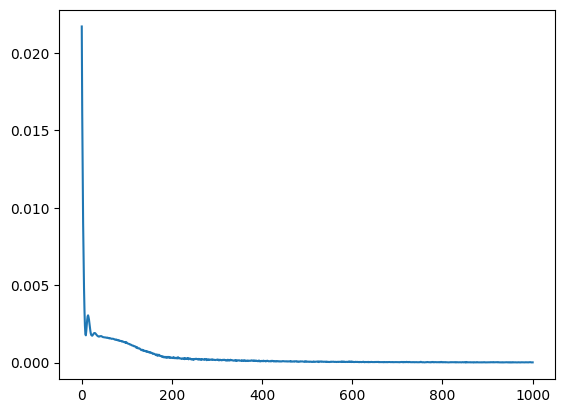

In [112]:
plt.plot(loss_list)

In [113]:
label_y, predicted = predict_mto(model, df, x_ss, y_ms)

48.73643517494202


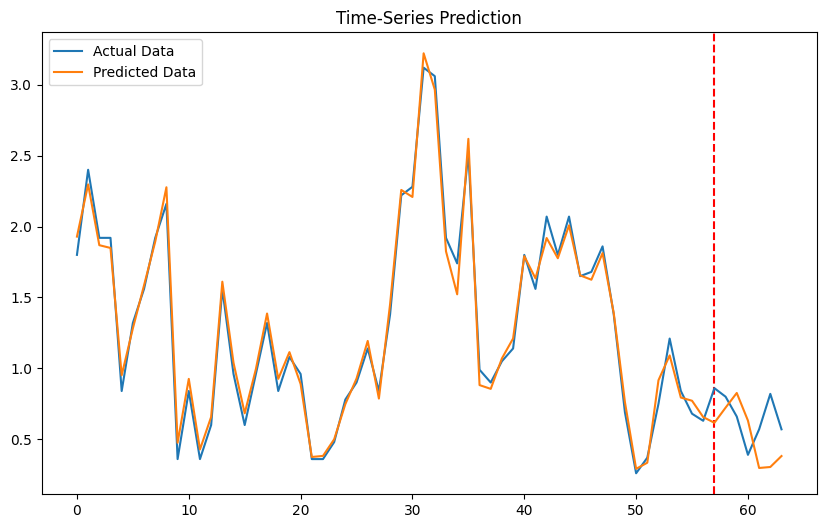

In [114]:
print(mape(label_y+1, predicted))
plotting(label_y, predicted, 57)

In [115]:
torch.save(model.state_dict(), 'Capstone/alpha_1week_BiLSTM.pth')

In [116]:
sub_df = pd.DataFrame()
sub_df['Date'] = data['stdDay'][62:].reset_index(drop = True)
sub_df['Actual_Data'] = label_y
sub_df['Predicted_Data'] = predicted

final_df = pd.DataFrame(index = range(76), columns = ['Date', 'Actual_Data', 'Predicted_Data'])
final_df[:len(sub_df)] = sub_df

for i in range(19):
    if i%3 == 0:
        final_df.iloc[57+i, :] = sub_df.iloc[57+(i//3), :]
    else:
        final_df.iloc[57+i, 0] = sub_df.iloc[57+(i//3), 0]
        final_df.iloc[57+i, 1:] = sub_df.iloc[57+(i//3), 1:] + ((i%3)/3) * (sub_df.iloc[58+(i//3), 1:] - sub_df.iloc[57+(i//3), 1:])

final_df.to_csv('Capstone/alpha_dailyInfected_BiLSTM.csv', encoding = 'cp949', index = False)

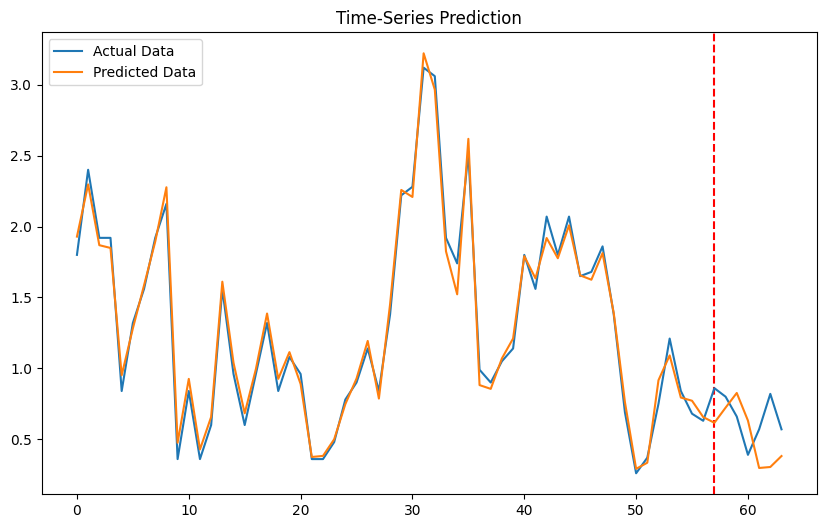

In [117]:
plotting(sub_df['Actual_Data'], sub_df['Predicted_Data'], 57)

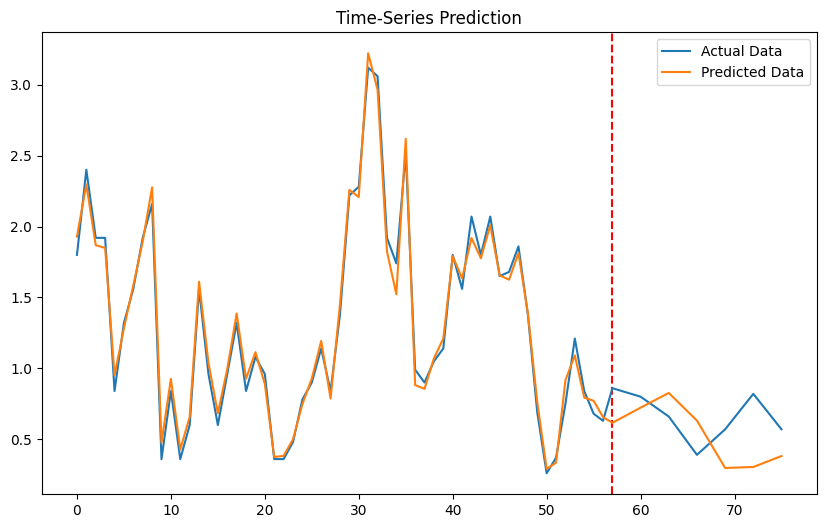

In [118]:
plotting(final_df['Actual_Data'], final_df['Predicted_Data'], 57)